In [1]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sgl

## 1

直接由定义式计算傅里叶变换的脚本如下：

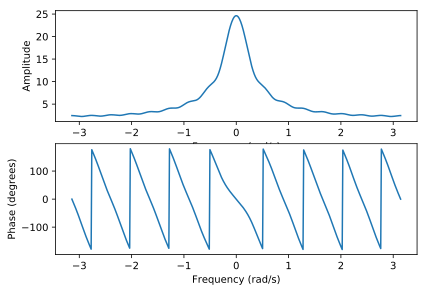

In [2]:
n = np.arange(-8,9,dtype=int)
N = 2**9;
x = 1.2**n
w = np.linspace(-np.pi,np.pi,N+1);

# DFT by definition
Sn = np.size(n)
Sw = np.size(w)
f = np.dot(n.reshape(Sn,1),w.reshape(1,Sw))
g = np.exp(-1j*f)
h = np.dot(x.reshape(1,Sn),g)
y1 = h.reshape(Sw)

fig, ax = plt.subplots(2,1,figsize=(6.5, 4.5))
ax[0].plot(w,abs(y1))
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Amplitude')
ax[1].plot(w,np.angle(y1)*180/np.pi)
ax[1].set_xlabel('Frequency (rad/s)')
ax[1].set_ylabel('Phase (degrees)')
plt.show()

用fft函数计算的脚本如下，因为原信号是从$n=-8$开始的，为了使计算得到的值与上面的结果相同，需要对信号进行一个时移变换（即在频域上加上一个相移，见脚本的第3行）：

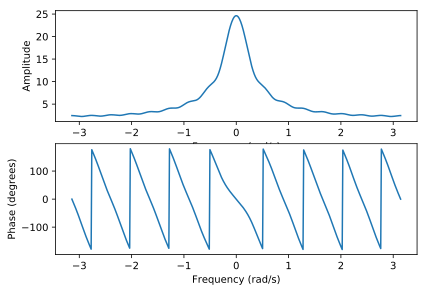

In [3]:
# DFT by FFT
y2 = np.fft.fftshift(np.fft.fft(x,N))
y2 = np.append(y2,y2[0])
y2 = y2*np.exp(-1j*w*(-8))
if sum(abs(y2-y1))>1.e-6:
    print('y2 and y1 not equal to each other.')

fig, ax = plt.subplots(2,1,figsize=(6.5, 4.5))
ax[0].plot(w,abs(y2))
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Amplitude')
ax[1].plot(w,np.angle(y2)*180/np.pi)
ax[1].set_xlabel('Frequency (rad/s)')
ax[1].set_ylabel('Phase (degrees)')
plt.show()

从上两张图可以看出，两者所得的结果完全相同。因此也验证了对于有限长离散时间信号，快速傅里叶变换所得的结果就是信号傅里叶变换在一个周期内的采样值。

## 2

信号的各频率分量分别为50, 100和150 Hz。不妨取采样频率为420 Hz, 并截取大于1/50\*100秒的信号进行分析：

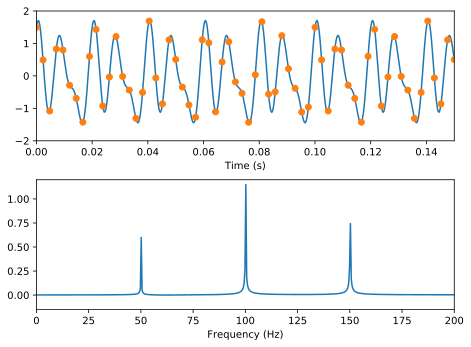

In [4]:
Ts = 1/420
tf = 1/50*100
N = int(2**np.ceil(np.log2(abs(tf/Ts))))
t = np.arange(0,N,dtype=int)*Ts;
w = np.linspace(-1,(N-1)/N,N)*np.pi/Ts

x = 0.5*np.sin(100*np.pi*t)+np.cos(200*np.pi*t)+0.7*np.sin(300*np.pi*t+np.pi/4)
y = np.fft.fftshift(np.fft.fft(x,N))*Ts

t1 = np.linspace(0,0.15,500)
x1 = 0.5*np.sin(100*np.pi*t1)+np.cos(200*np.pi*t1)+0.7*np.sin(300*np.pi*t1+np.pi/4)
fig, ax = plt.subplots(2,1,figsize=(7.5, 5.5))
ax[0].plot(t1,x1,t,x,'o')
ax[0].set_xlabel('Time (s)')
ax[0].axis([0,0.15,-2,2])
ax[1].plot(w/2/np.pi,np.abs(y))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].axis([0,200,-0.15,1.2])
fig.subplots_adjust(hspace=0.3)
plt.show()

加入噪声：

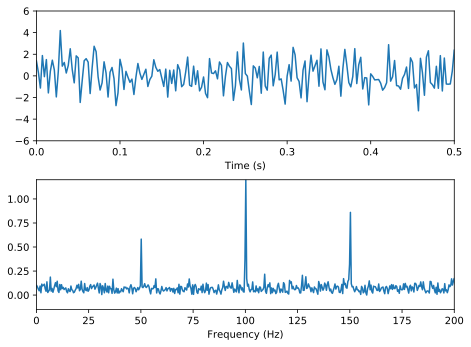

In [5]:
sn = np.random.randn(np.size(t))
xn = x+sn
yn = np.fft.fftshift(np.fft.fft(xn,N))*Ts

fig, ax = plt.subplots(2,1,figsize=(7.5, 5.5))
ax[0].plot(t,xn)
ax[0].set_xlabel('Time (s)')
ax[0].axis([0,0.5,-6,6])
ax[1].plot(w/2/np.pi,np.abs(yn))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].axis([0,200,-0.15,1.2])
fig.subplots_adjust(hspace=0.3)
plt.show()

通过频谱可以清楚地看出信号的各个频率分量（分别为50Hz, 100Hz和150hz），由于噪声的频谱仍是噪声（见以下的脚本和图），因此时域上信号即使淹没在噪声中，在频域上仍能很好地分辨。

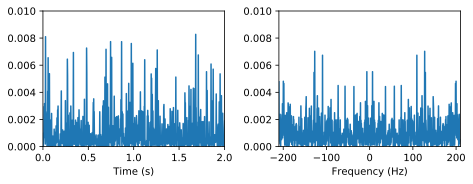

In [6]:
ysn = np.fft.fftshift(np.fft.fft(sn,N))*Ts
et = sum(abs(sn)*abs(sn))*Ts
ef = sum(abs(ysn)*abs(ysn))/Ts/N
if abs(et-ef)>1.e-6:
    print('Energy not inconsistent.')

fig, ax = plt.subplots(1,2,figsize=(7.5, 2.5))
ax[0].plot(t,abs(sn)*abs(sn)*Ts/et)
ax[0].set_xlabel('Time (s)')
ax[0].axis([0,tf,0,0.01])
ax[1].plot(w/2/np.pi,abs(ysn)*abs(ysn)/Ts/N/et)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].axis([-210,210,0,0.01])
fig.subplots_adjust(wspace=0.3)
plt.show()

为便于比较，上图中的信号大小经过了归一化。通过脚本也可以看出变换前后帕斯瓦尔定理成立。

## 3

首先根据时间常数$\tau=RC$确定了较为合适的时间区间、样本个数和采样时间间隔:

In [7]:
C = 22e-6
R = 510
tau = R*C
tf = tau*50
Ts = tau/50
N = int(2**np.ceil(np.log2(abs(tf/Ts))))
t = np.arange(0,N)*Ts

计算并画出电路的频率响应：

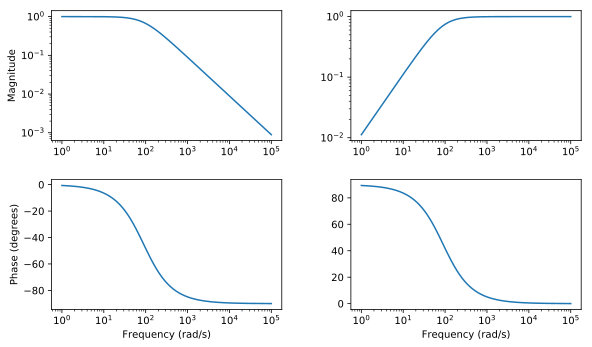

In [8]:
w = np.logspace(0,5,N)
H1=sgl.freqs([0,1],[tau,1],w)
H2=sgl.freqs([tau,0],[tau,1],w)

fig, ax = plt.subplots(2,2,figsize=(9.5, 5.5))
ax[0,0].plot(w,abs(H1[1]))
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Magnitude')
ax[0,1].plot(w,abs(H2[1]))
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[1,0].plot(w,np.angle(H1[1])*180/np.pi)
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('Frequency (rad/s)')
ax[1,0].set_ylabel('Phase (degrees)')
ax[1,1].plot(w,np.angle(H2[1])*180/np.pi)
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('Frequency (rad/s)')
fig.subplots_adjust(wspace=0.3, hspace=0.3)


计算输入信号(矩形脉冲)的傅里叶变换，经过频域的相乘及傅里叶反变换即得到时域上的响应：

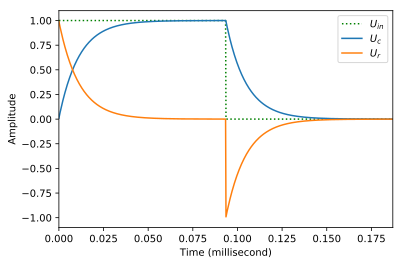

In [9]:
w = np.linspace(-0.5,(N-1)/N-0.5,N)*2*np.pi/Ts
H1 = sgl.freqs([0,1],[tau,1],w)
H2 = sgl.freqs([tau,0],[tau,1],w)

x = np.zeros(len(t))
idx = np.where(t<tf/6)
x[idx] = 1.

X = np.fft.fft(x)*Ts

Y1 = H1[1]*np.fft.ifftshift(X)
Y2 = H2[1]*np.fft.ifftshift(X)
y1 = np.fft.ifft(np.fft.fftshift(Y1))/Ts
y2 = np.fft.ifft(np.fft.fftshift(Y2))/Ts


fig, ax = plt.subplots()
ax.plot(t,x,'g:', t,np.real(y1), t,np.real(y2))
ax.axis([0,tf/3,-1.1,1.1])
ax.set_xlabel('Time (millisecond)')
ax.set_ylabel('Amplitude')
plt.legend(('$U_{in}$','$U_c$','$U_r$'))
plt.show()

## 4

In [10]:
Tf = 10
N = 2**10
Ts = Tf/N;
t = np.arange(0,N)*Ts;

(a) 系统的幅频特性和相频特性：

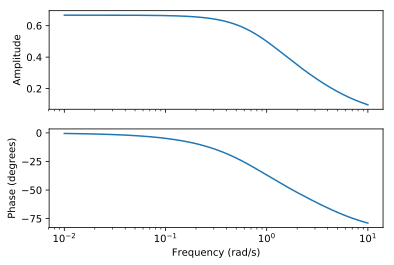

In [11]:
H = sgl.freqs([1,2],[1,4,3])

fig, ax = plt.subplots(2,1,sharex='col')
ax[0].plot(H[0],abs(H[1]))
ax[0].set_xscale('log')
ax[0].set_ylabel('Amplitude')
ax[1].plot(H[0],np.angle(H[1])*180/np.pi)
ax[1].set_xscale('log')
ax[1].set_xlabel('Frequency (rad/s)')
ax[1].set_ylabel('Phase (degrees)')
plt.show()

系统的单位冲激响应是系统频率响应的傅里叶逆变换：

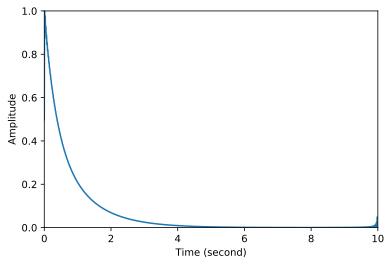

In [12]:
w = np.linspace(-0.5,(N-1)/N-0.5,N)*2*np.pi/Ts

H = sgl.freqs([1,2],[1,4,3],w)
h = np.fft.ifft(np.fft.fftshift(H[1]))/Ts

fig, ax = plt.subplots()
ax.plot(t, np.real(h))
ax.set_xlabel('Time (second)')
ax.set_ylabel('Amplitude')
ax.axis([0,10,0,1])
plt.show()

系统的零状态响应。不难求出系统系统单位冲激响应的解析解为$$h\left( t \right) = \left( {\frac{1}{2}{e^{ - t}} + \frac{1}{2}{e^{ - 3t}}} \right)u\left( t \right)\;,$$当输入信号为$x\left( t \right) = {e^{ - t}}u\left( t \right)$时，系统的零状态响应为$$y\left( t \right) = \left( {\frac{1}{2}t{e^{ - t}} + \frac{1}{4}{e^{ - t}} - \frac{1}{4}{e^{ - 3t}}} \right)u\left( t \right)\;.$$以下脚本给出了数值解和解析解的比较，可以看出两者给出的结果是一致的。

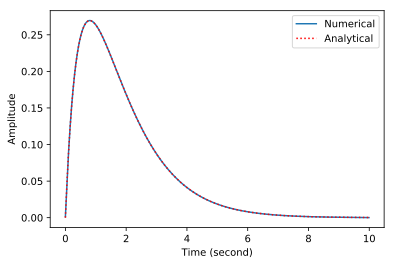

In [13]:
X = 1/(1+1j*w)
Y = H[1]*X

y = np.fft.ifft(np.fft.fftshift(Y))/Ts
y1 = 0.5*t*np.exp(-t)+0.25*np.exp(-t)-0.25*np.exp(-3*t)

fig, ax = plt.subplots()
ax.plot(t, np.real(y), t, y1,'r:')
ax.set_xlabel('Time (second)')
ax.set_ylabel('Amplitude')
plt.legend(('Numerical','Analytical'))
plt.show()